In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.io import loadmat
import pandas as pd
import os
import glob


In [2]:
def get_regression_model(model_name):
    if model_name.lower() == 'linear':
        return LinearRegression()
    elif model_name.lower() == 'svr':
        # SVR does not support multi-target regression, so we wrap it.
        return MultiOutputRegressor(SVR())
    elif model_name.lower() == 'rf' or model_name.lower() == 'randomforest':
        return RandomForestRegressor()
    elif model_name.lower() == 'gbr' or model_name.lower() == 'gradientboosting':
        return GradientBoostingRegressor()
    else:
        raise ValueError(f"Unsupported model: {model_name}")



In [3]:
# Build a pipeline that includes PCA and the regression model.
def build_pipeline(n_components, model_name):
    pca = PCA(n_components=n_components)
    regressor = get_regression_model(model_name)
    
    pipeline = Pipeline([
        # ('pca', pca),
        ('regressor', regressor)
    ])
    return pipeline



In [4]:
def sync_eyepos_to_frame(df, step=2.5):
    n = len(df.columns)
    sample_indices = np.arange(0, n, step)
    sampled_cols = []
    
    for idx in sample_indices:
        if idx.is_integer():
            # Directly take the integer-indexed column.
            sample = df.iloc[:, int(idx)]
        else:
            lower = int(np.floor(idx))
            upper = int(np.ceil(idx))
            if upper >= n:
                sample = df.iloc[:, lower]
            else:
                col_lower = df.iloc[:, lower]
                col_upper = df.iloc[:, upper]
                sample = (col_lower + col_upper) / 2.0
        sampled_cols.append(sample)
    
    # Concatenate the columns into a new DataFrame.
    new_df = pd.concat(sampled_cols, axis=1)
    new_df.columns = sample_indices  # Optionally, set the columns to the sampling positions.
    return new_df



In [24]:
# Define the folder path containing all .mat files (each representing one trial)
folder_path1 = r"C:\\Users\\itama\\Desktop\\gandalf_toy_data\\gandalf_130618c_old"
folder_path2 = r"C:\\Users\\itama\\Desktop\\gandalf_toy_data\\gandalf_130618d"
mat_files1 = glob.glob(os.path.join(folder_path1, '*.mat'))
mat_files2 = glob.glob(os.path.join(folder_path2, '*.mat'))
mat_files = mat_files1 + mat_files2
# Lists to hold the data from each trial.
list_of_X = []
list_of_y = []

for mat_file in mat_files:
    # Load the .mat file for one trial.
    mat_data = loadmat(mat_file)
    
    # Extract the MATLAB matrices. Adjust the variable names if needed.
    VSD_data = mat_data['VSDdata']
    eye_pos = mat_data['eyePosition']
    
    # Process VSD_data: take only the first 121 columns and transpose.
    VSD_data_df = pd.DataFrame(VSD_data).iloc[:, :121].T
    # Process eye_pos: convert to DataFrame and align eye position to frames.
    eye_pos_df = pd.DataFrame(eye_pos)
    eye_pos_df = sync_eyepos_to_frame(eye_pos_df).T.reset_index(drop=True)
    start_time = 35
    end_time = 50
    eye_VSD_delay = 5
    eye_pos_df_avg = eye_pos_df.iloc[start_time - eye_VSD_delay: end_time - eye_VSD_delay, :].mean(axis=0)
    VSD_data_df_avg = VSD_data_df.iloc[start_time:end_time, :].mean(axis=0)
    # Append the current trial's data.
    list_of_X.append(VSD_data_df_avg)
    list_of_y.append(eye_pos_df_avg)



grid search for finding the best start, end, delay times

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Assuming build_pipeline and sync_eyepos_to_frame are defined as in your code

# Define folder paths and load all .mat files.
folder_path1 = r"C:\Users\itama\Desktop\gandalf_toy_data\gandalf_130618c_old"
folder_path2 = r"C:\Users\itama\Desktop\gandalf_toy_data\gandalf_130618d"
mat_files1 = glob.glob(os.path.join(folder_path1, '*.mat'))
mat_files2 = glob.glob(os.path.join(folder_path2, '*.mat'))
mat_files = mat_files1 + mat_files2

# Candidate hyperparameters.
candidate_start_times = list(range(30, 41, 2))     # For example, try these start times.
candidate_end_times   = list(range(45, 55, 2))      # For example, try these end times.
candidate_delays      = [3, 4, 5, 6, 7]          # Candidate eye_VSD_delay values.

# Fixed settings for the regression pipeline.
n_components = 50
model_name   = 'linear'

# To store results for each hyperparameter combination.
results = []

# Loop over candidate hyperparameters.
for start_time in candidate_start_times:
    for end_time in candidate_end_times:
        for delay in candidate_delays:
            X_all_avg = []
            y_all_avg = []
            
            # Process each trial.
            for mat_file in mat_files:
                try:
                    mat_data = loadmat(mat_file)
                except Exception as e:
                    print(f"Error loading {mat_file}: {e}")
                    continue
                
                # Check if the required variables are present.
                if 'VSDdata' not in mat_data or 'eyePosition' not in mat_data:
                    continue
                
                VSD_data = mat_data['VSDdata']
                eye_pos  = mat_data['eyePosition']
                
                # Process VSD_data: take only the first 121 columns and transpose.
                VSD_data_df = pd.DataFrame(VSD_data).iloc[:, :121].T
                # Process eye_pos: convert to DataFrame, align to frames, and transpose.
                eye_pos_df = pd.DataFrame(eye_pos)
                eye_pos_df = sync_eyepos_to_frame(eye_pos_df).T
                
                # Check if the indices are valid for this trial.
                if end_time > VSD_data_df.shape[0]:
                    continue
                if (start_time - delay) < 0 or (end_time - delay) > eye_pos_df.shape[0]:
                    continue
                
                # Average over the specified windows.
                VSD_data_df_avg = VSD_data_df.iloc[start_time:end_time, :].mean(axis=0)
                eye_pos_df_avg  = eye_pos_df.iloc[start_time - delay:end_time - delay, :].mean(axis=0)
                
                X_all_avg.append(VSD_data_df_avg)
                y_all_avg.append(eye_pos_df_avg)
            
            # Skip if too few trials are available.
            if len(X_all_avg) < 2 or len(y_all_avg) < 2:
                continue
            
            X_all_avg = pd.DataFrame(X_all_avg)
            y_all_avg = pd.DataFrame(y_all_avg)
            
            # Split data into training and test sets.
            X_train, X_test, y_train, y_test = train_test_split(
                X_all_avg, y_all_avg, test_size=0.2, random_state=42)
            
            # Build and train the regression pipeline.
            pipeline = build_pipeline(n_components, model_name)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            results.append({
                'start_time': start_time,
                'end_time': end_time,
                'delay': delay,
                'mse': mse
            })

# Convert results to a DataFrame.
results_df = pd.DataFrame(results)
print("Grid Search Results:")
print(results_df)



In [ ]:
results_df.sort_values("mse")


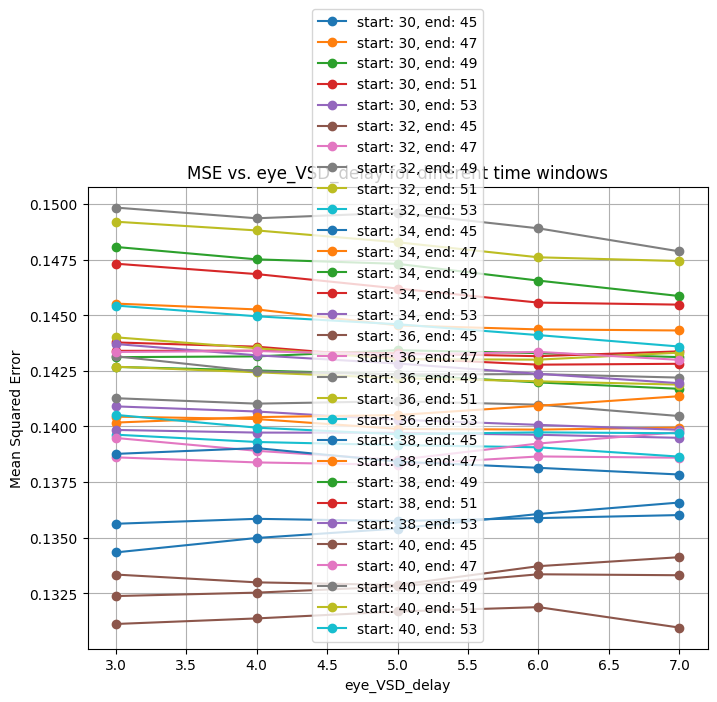

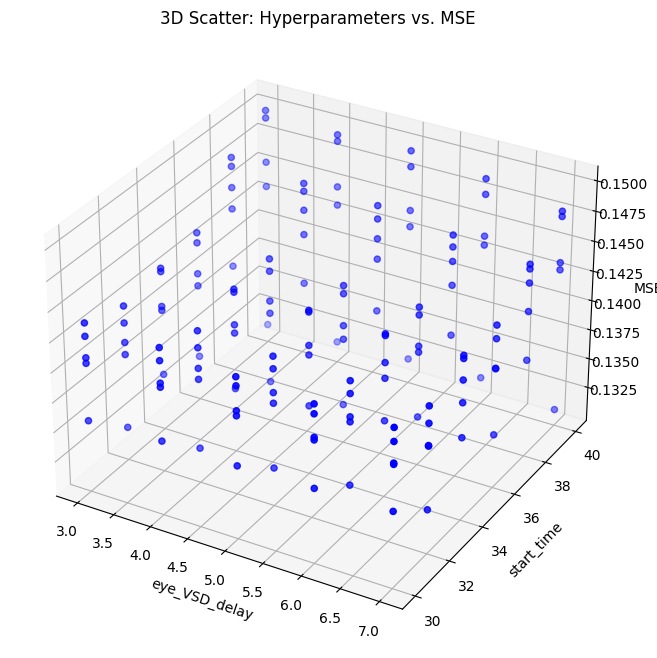

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [40]:
# --------------------
# Plotting Option 1:
# For each fixed (start_time, end_time) combination, plot MSE vs. eye_VSD_delay.
fig, ax = plt.subplots(figsize=(8,6))
for (st, et), group in results_df.groupby(['start_time', 'end_time']):
    ax.plot(group['delay'], group['mse'], marker='o', label=f"start: {st}, end: {et}")
ax.set_xlabel("eye_VSD_delay")
ax.set_ylabel("Mean Squared Error")
ax.set_title("MSE vs. eye_VSD_delay for different time windows")
ax.legend()
ax.grid(True)
plt.show()

# --------------------
# Plotting Option 2:
# 3D scatter plot to see the relation between delay, start_time, and MSE.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax3d = fig.add_subplot(111, projection='3d')
ax3d.scatter(results_df['delay'], results_df['start_time'], results_df['mse'], c='b', marker='o')
ax3d.set_xlabel("eye_VSD_delay")
ax3d.set_ylabel("start_time")
ax3d.set_zlabel("MSE")
ax3d.set_title("3D Scatter: Hyperparameters vs. MSE")
plt.show()

# --------------------
# Plotting Option 3:
# If you have multiple start_time values and delays, create a heatmap.
import seaborn as sns
if results_df['start_time'].nunique() > 1 and results_df['delay'].nunique() > 1:
    heatmap_data = results_df.pivot("start_time", "delay", "mse")
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Heatmap of MSE by start_time and eye_VSD_delay")
    plt.show()

# Identify the best hyperparameter combination.
if not results_df.empty:
    best_idx = results_df['mse'].idxmin()
    best_params = results_df.loc[best_idx]
    print("Best hyperparameters:")
    print(best_params)


In [ ]:
# Split the combined data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(list_of_X, list_of_y, test_size=0.2, random_state=17)

# Set the number of principal components and choose a regression model.
n_components = 50  # Adjust based on your variance explained criterion
model_name = 'linear'  # Options: 'linear', 'svr', 'rf', 'gbr'

# Build and train the pipeline.
pipeline = build_pipeline(n_components, model_name)
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set.
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

In [34]:
X_train[1]

0       0.998585
1       0.993961
2       1.000806
3       1.002689
4       0.998146
          ...   
9995    1.002411
9996    1.000406
9997    1.001497
9998    1.000569
9999    0.998777
Length: 10000, dtype: float64

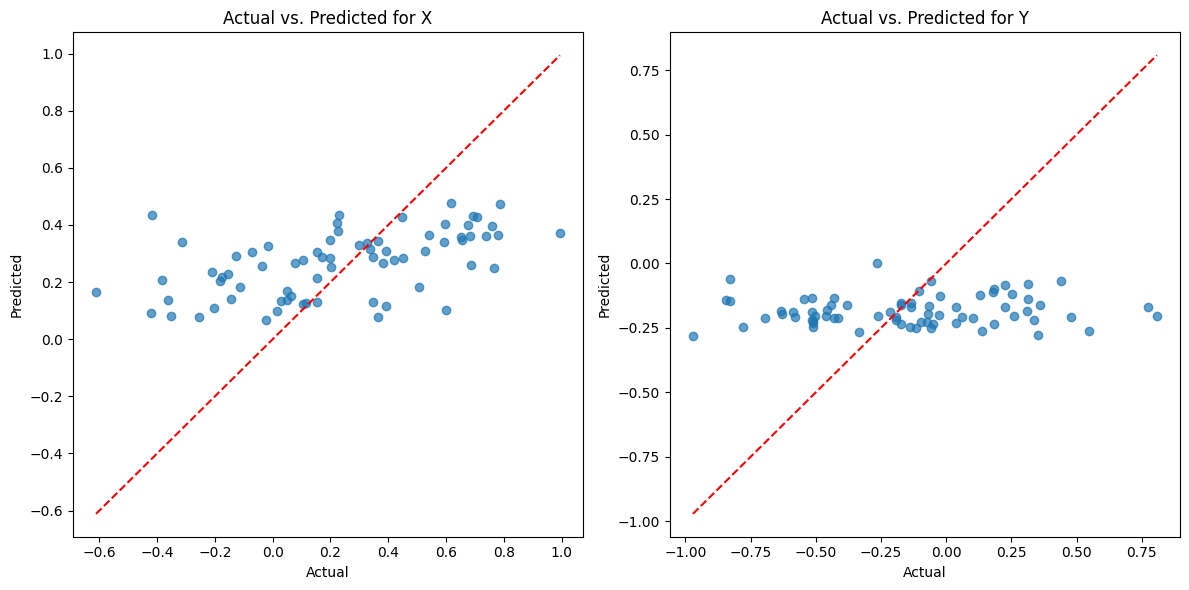

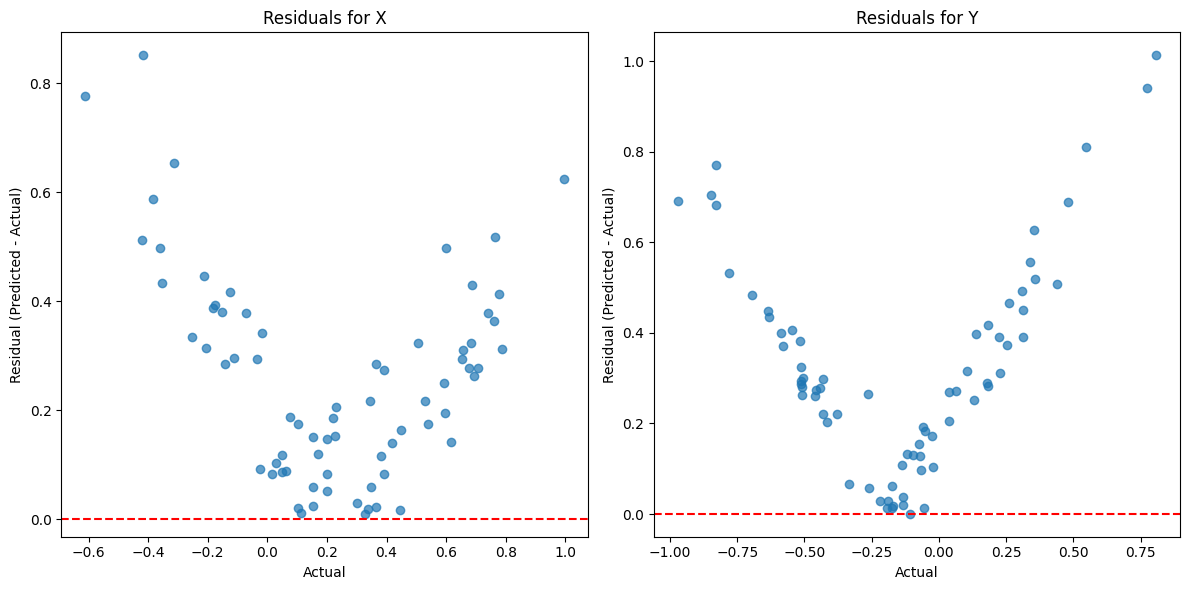

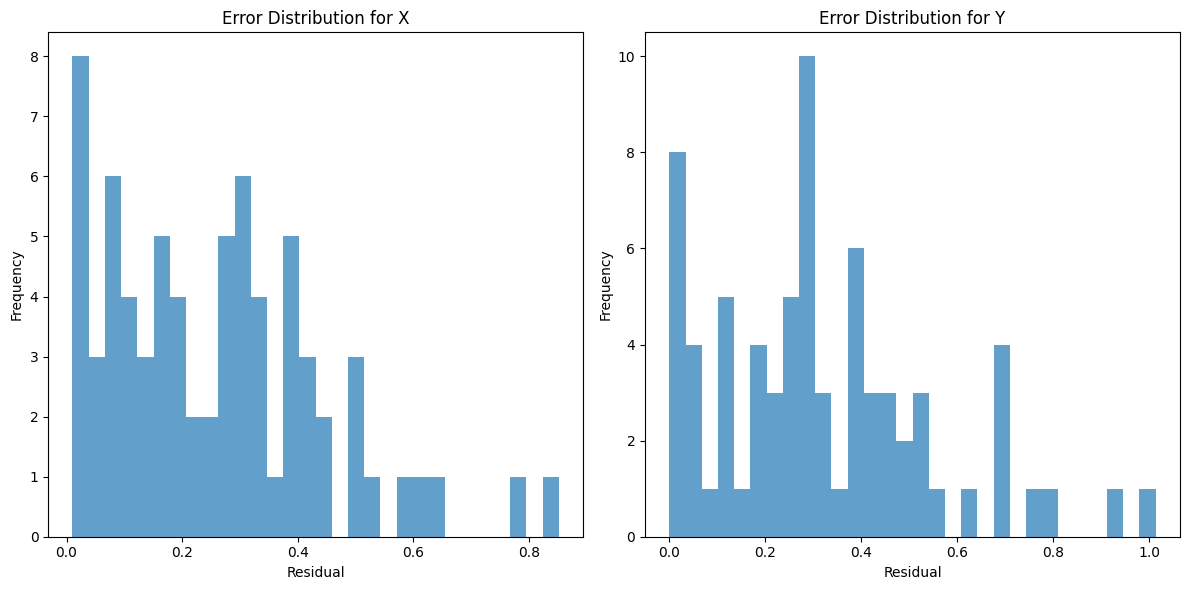

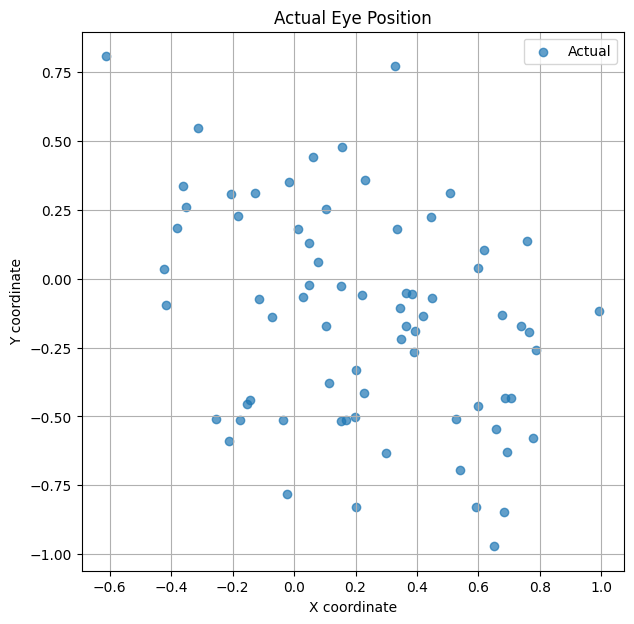

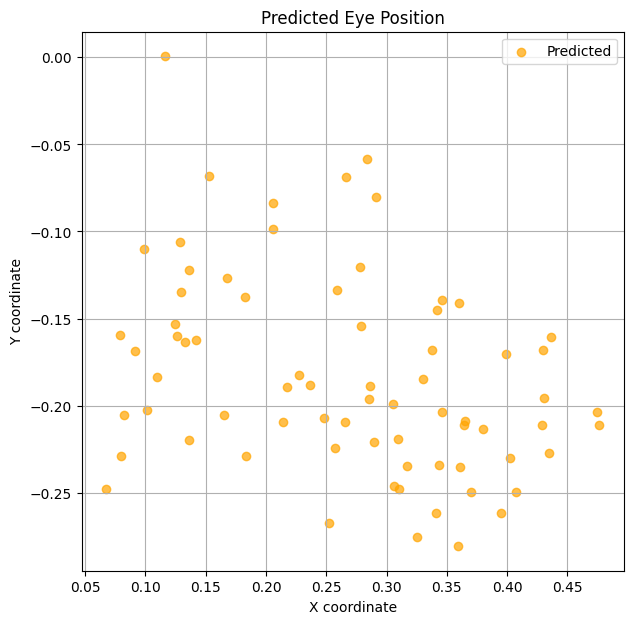

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test and y_pred to NumPy arrays if they're not already.
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

target_names = ['X', 'Y']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].scatter(y_test_arr[:, i], y_pred_arr[:, i], alpha=0.7)
    axs[i].set_title(f"Actual vs. Predicted for {target_names[i]}")
    axs[i].set_xlabel("Actual")
    axs[i].set_ylabel("Predicted")
    # Plot a reference line y = x.
    min_val = min(y_test_arr[:, i].min(), y_pred_arr[:, i].min())
    max_val = max(y_test_arr[:, i].max(), y_pred_arr[:, i].max())
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.show()


# Calculate residuals.
residuals = abs(y_pred_arr - y_test_arr)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].scatter(y_test_arr[:, i], residuals[:, i], alpha=0.7)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(f"Residuals for {target_names[i]}")
    axs[i].set_xlabel("Actual")
    axs[i].set_ylabel("Residual (Predicted - Actual)")
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist(residuals[:, i], bins=30, alpha=0.7)
    axs[i].set_title(f"Error Distribution for {target_names[i]}")
    axs[i].set_xlabel("Residual")
    axs[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Convert y_test and y_pred to NumPy arrays if necessary.
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

# Plot for the actual (test) coordinates.
plt.figure(figsize=(7, 7))
plt.scatter(y_test_arr[:, 0], y_test_arr[:, 1], alpha=0.7, label="Actual")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Actual Eye Position")
plt.legend()
plt.grid(True)
plt.show()

# Plot for the predicted coordinates.
plt.figure(figsize=(7, 7))
plt.scatter(y_pred_arr[:, 0], y_pred_arr[:, 1], alpha=0.7, color='orange', label="Predicted")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Predicted Eye Position")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
eye_pos_df.loc[40:45]

,0,1
40.0,0.061445,0.259219
42.5,0.071686,0.229309
45.0,0.102408,0.229309


In [53]:
# Convert the list of Pandas Series to a NumPy array.
# Each series is converted to an array and then stacked as rows.
y_array = np.vstack([s.values for s in eye_pos_df[2]])

# Compute differences between consecutive samples (rows).
diff = np.diff(y_array, axis=0)

# Calculate the Euclidean distance for each consecutive pair.
distances = np.sqrt(np.sum(diff**2, axis=1))

# Plot the distances.
plt.figure(figsize=(10, 6))
plt.plot(distances, marker='o')
plt.xlabel("Sample Index")
plt.ylabel("Distance Moved")
plt.title("Distance Moved Between Consecutive Eye Position Samples")
plt.grid(True)
plt.show()


KeyError: 2

In [ ]:
residuals

array([[7.000e-02, 4.090e-01],
       [1.850e-01, 3.370e-01],
       [5.780e-01, 1.740e-01],
       [9.100e-02, 3.130e-01],
       [6.400e-01, 3.680e-01],
       [1.480e-01, 2.000e-03],
       [3.160e-01, 1.800e-01],
       [4.100e-02, 1.410e-01],
       [2.390e-01, 1.300e-02],
       [1.470e-01, 1.003e+00],
       [4.600e-02, 4.590e-01],
       [4.600e-02, 3.010e-01],
       [4.270e-01, 1.200e-01],
       [2.500e-02, 2.070e-01],
       [1.460e-01, 8.830e-01],
       [1.040e-01, 3.480e-01],
       [1.830e-01, 1.460e-01],
       [1.960e-01, 6.420e-01],
       [2.900e-01, 1.310e-01],
       [1.760e-01, 1.000e-03],
       [7.580e-01, 5.360e-01],
       [3.210e-01, 2.050e-01],
       [6.300e-02, 3.980e-01],
       [1.220e-01, 5.710e-01],
       [2.270e-01, 3.080e-01],
       [1.220e-01, 9.000e-02],
       [3.340e-01, 3.440e-01],
       [7.000e-03, 4.490e-01],
       [9.620e-01, 1.199e+00],
       [2.270e-01, 3.000e-02],
       [3.120e-01, 3.060e-01],
       [1.850e-01, 2.800e-02],
       [